In [1]:
# -*- coding: utf-8 -*-
"""Deep_Residual_Learning_VS_Deep_Learning_for_Image_Recognition_56.ipynb

Automatically generated by Colab.

Original file is located at
    https://colab.research.google.com/drive/1R8CsamO9yz9R5cvQIWqugncOdd3cuaYT
"""

!pip install torch torchvision matplotlib tensorboard

!pip install tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
import numpy as np
import os
from tqdm import tqdm
import pandas as pd
from sklearn.metrics import confusion_matrix

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 114.1 MB/s eta 0:00:0000:01:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 85.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 17.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 85.2 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5

2025-09-13 10:29:13.187461: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1757759353.420243      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1757759353.485950      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Using device: cuda


In [2]:


# Data preprocessing
mean = [0.4914, 0.4822, 0.4465]
std = [0.247, 0.243, 0.261]

transform_train = transforms.Compose([
    transforms.Pad(4),
    transforms.RandomCrop(32),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

# Model Definitions
class BasicBlock(nn.Module):  # For ResNet56
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class PlainBlock(nn.Module):  # For PlainNet56
    def __init__(self, in_planes, planes, stride=1):
        super(PlainBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 16

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)
        self.linear = nn.Linear(64, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, 8)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

class PlainNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(PlainNet, self).__init__()
        self.in_planes = 16

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)
        self.linear = nn.Linear(64, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, 8)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

# Model constructors for 56 layers
def ResNet56():
    return ResNet(BasicBlock, [9, 9, 9])  # 56 layers

def PlainNet56():
    return PlainNet(PlainBlock, [9, 9, 9])  # 56 layers

# Training Functions
criterion = nn.CrossEntropyLoss()
writer = SummaryWriter('runs/cifar10_56')

def train(model, trainloader, optimizer, epoch, tag):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in tqdm(trainloader, desc=f"Epoch {epoch+1} - {tag} Train", unit="batch"):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    train_loss = running_loss / len(trainloader)
    train_acc = 100. * correct / total
    writer.add_scalar(f'Loss/train_{tag}', train_loss, epoch)
    writer.add_scalar(f'Accuracy/train_{tag}', train_acc, epoch)
    return train_loss, train_acc

def test(model, testloader, epoch, tag):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in tqdm(testloader, desc=f"Epoch {epoch+1} - {tag} Test", unit="batch"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    test_loss = running_loss / len(testloader)
    test_acc = 100. * correct / total
    writer.add_scalar(f'Loss/test_{tag}', test_loss, epoch)
    writer.add_scalar(f'Accuracy/test_{tag}', test_acc, epoch)
    return test_loss, test_acc

# Initialize models
plain_net = PlainNet56().to(device)
res_net = ResNet56().to(device)

optimizer_plain = optim.SGD(plain_net.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)
optimizer_res = optim.SGD(res_net.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)

scheduler_plain = optim.lr_scheduler.MultiStepLR(optimizer_plain, milestones=[80, 120], gamma=0.1)
scheduler_res = optim.lr_scheduler.MultiStepLR(optimizer_res, milestones=[80, 120], gamma=0.1)

# Logs
plain_logs = {'train_loss': [], 'train_acc': [], 'test_loss': [], 'test_acc': []}
res_logs = {'train_loss': [], 'train_acc': [], 'test_loss': [], 'test_acc': []}

# Training loop
epochs = 200
for epoch in range(epochs):
    train_loss, train_acc = train(plain_net, trainloader, optimizer_plain, epoch, 'Plain56')
    test_loss, test_acc = test(plain_net, testloader, epoch, 'Plain56')
    plain_logs['train_loss'].append(train_loss)
    plain_logs['train_acc'].append(train_acc)
    plain_logs['test_loss'].append(test_loss)
    plain_logs['test_acc'].append(test_acc)

    train_loss, train_acc = train(res_net, trainloader, optimizer_res, epoch, 'ResNet56')
    test_loss, test_acc = test(res_net, testloader, epoch, 'ResNet56')
    res_logs['train_loss'].append(train_loss)
    res_logs['train_acc'].append(train_acc)
    res_logs['test_loss'].append(test_loss)
    res_logs['test_acc'].append(test_acc)

    scheduler_plain.step()
    scheduler_res.step()

    if (epoch + 1) % 20 == 0:
        print(f"Epoch {epoch+1}: Plain56 Test Acc: {plain_logs['test_acc'][-1]:.2f}%, ResNet56 Test Acc: {res_logs['test_acc'][-1]:.2f}%")

# Save models and logs
torch.save(plain_net.state_dict(), 'plain56.pth')
torch.save(res_net.state_dict(), 'resnet56.pth')
pd.DataFrame(plain_logs).to_csv('plain56_logs.csv', index=False)
pd.DataFrame(res_logs).to_csv('resnet56_logs.csv', index=False)

# Plots
epochs_range = range(epochs)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, plain_logs['test_acc'], label='Plain56 Test Acc')
plt.plot(epochs_range, res_logs['test_acc'], label='ResNet56 Test Acc')
plt.plot(epochs_range, plain_logs['train_acc'], label='Plain56 Train Acc', linestyle='--')
plt.plot(epochs_range, res_logs['train_acc'], label='ResNet56 Train Acc', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Curves (56 layers)')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, plain_logs['test_loss'], label='Plain56 Test Loss')
plt.plot(epochs_range, res_logs['test_loss'], label='ResNet56 Test Loss')
plt.plot(epochs_range, plain_logs['train_loss'], label='Plain56 Train Loss', linestyle='--')
plt.plot(epochs_range, res_logs['train_loss'], label='ResNet56 Train Loss', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curves (56 layers)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('accuracy_loss_56.png')
plt.close()

# Confusion Matrices
plt.figure(figsize=(12, 5))

for i, (name, model, color) in enumerate([('Plain56', plain_net, 'Blues'), ('ResNet56', res_net, 'Oranges')], 1):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    cm = confusion_matrix(all_labels, all_preds)

    plt.subplot(1, 2, i)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.get_cmap(color))
    plt.title(f'{name} Confusion Matrix')
    plt.colorbar()
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.xticks(np.arange(10))
    plt.yticks(np.arange(10))

plt.tight_layout()
plt.savefig('confusion_56.png')
plt.close()

# Final Accuracies
print(f"Plain56 Final Test Acc: {plain_logs['test_acc'][-1]:.2f}%")
print(f"ResNet56 Final Test Acc: {res_logs['test_acc'][-1]:.2f}%")

100%|██████████| 170M/170M [00:09<00:00, 17.3MB/s] 
Epoch 20 - ResNet56 Test: 100%|██████████| 79/79 [00:01<00:00, 43.95batch/s]


Epoch 20: Plain56 Test Acc: 48.46%, ResNet56 Test Acc: 85.30%


Epoch 40 - ResNet56 Test: 100%|██████████| 79/79 [00:01<00:00, 44.18batch/s]


Epoch 40: Plain56 Test Acc: 67.10%, ResNet56 Test Acc: 86.17%


Epoch 60 - ResNet56 Test: 100%|██████████| 79/79 [00:01<00:00, 46.57batch/s]


Epoch 60: Plain56 Test Acc: 73.04%, ResNet56 Test Acc: 88.54%


Epoch 80 - ResNet56 Test: 100%|██████████| 79/79 [00:01<00:00, 44.90batch/s]


Epoch 80: Plain56 Test Acc: 74.75%, ResNet56 Test Acc: 88.24%


Epoch 100 - ResNet56 Test: 100%|██████████| 79/79 [00:01<00:00, 45.45batch/s]


Epoch 100: Plain56 Test Acc: 85.76%, ResNet56 Test Acc: 92.21%


Epoch 120 - ResNet56 Test: 100%|██████████| 79/79 [00:01<00:00, 43.34batch/s]


Epoch 120: Plain56 Test Acc: 86.22%, ResNet56 Test Acc: 92.41%


Epoch 140 - ResNet56 Test: 100%|██████████| 79/79 [00:01<00:00, 43.07batch/s]


Epoch 140: Plain56 Test Acc: 86.39%, ResNet56 Test Acc: 92.55%


Epoch 160 - ResNet56 Test: 100%|██████████| 79/79 [00:01<00:00, 44.22batch/s]


Epoch 160: Plain56 Test Acc: 86.54%, ResNet56 Test Acc: 92.54%


Epoch 180 - ResNet56 Test: 100%|██████████| 79/79 [00:01<00:00, 42.49batch/s]


Epoch 180: Plain56 Test Acc: 86.52%, ResNet56 Test Acc: 92.58%


Epoch 200 - ResNet56 Test: 100%|██████████| 79/79 [00:01<00:00, 42.66batch/s]


Epoch 200: Plain56 Test Acc: 86.34%, ResNet56 Test Acc: 92.59%


/tmp/ipykernel_36/2120812797.py:265: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.imshow(cm, interpolation='nearest', cmap=plt.cm.get_cmap(color))
/tmp/ipykernel_36/2120812797.py:265: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.imshow(cm, interpolation='nearest', cmap=plt.cm.get_cmap(color))


Plain56 Final Test Acc: 86.34%
ResNet56 Final Test Acc: 92.59%


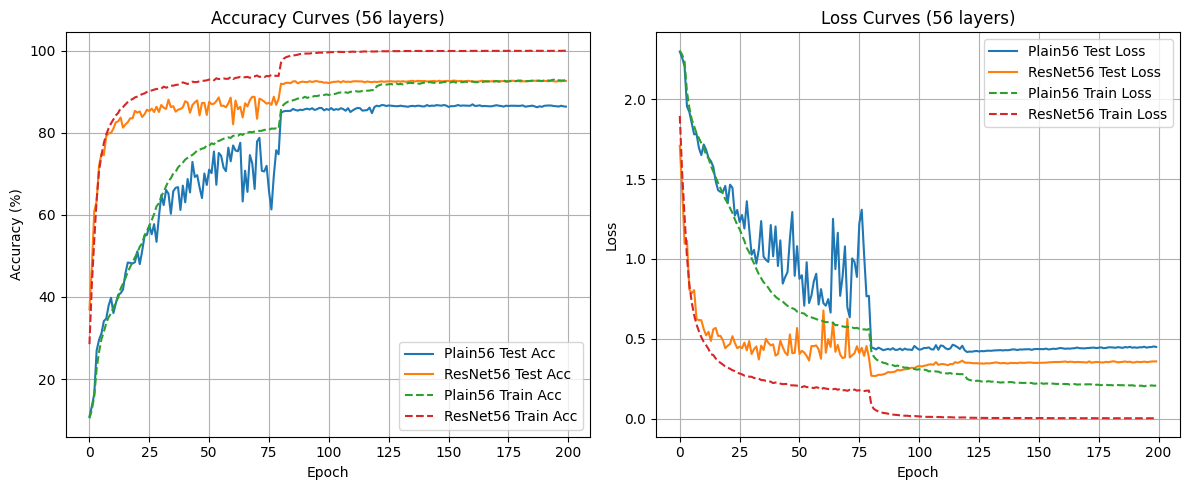

/tmp/ipykernel_36/1859742789.py:52: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.imshow(cm, interpolation='nearest', cmap=plt.cm.get_cmap(color))
/tmp/ipykernel_36/1859742789.py:52: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  plt.imshow(cm, interpolation='nearest', cmap=plt.cm.get_cmap(color))


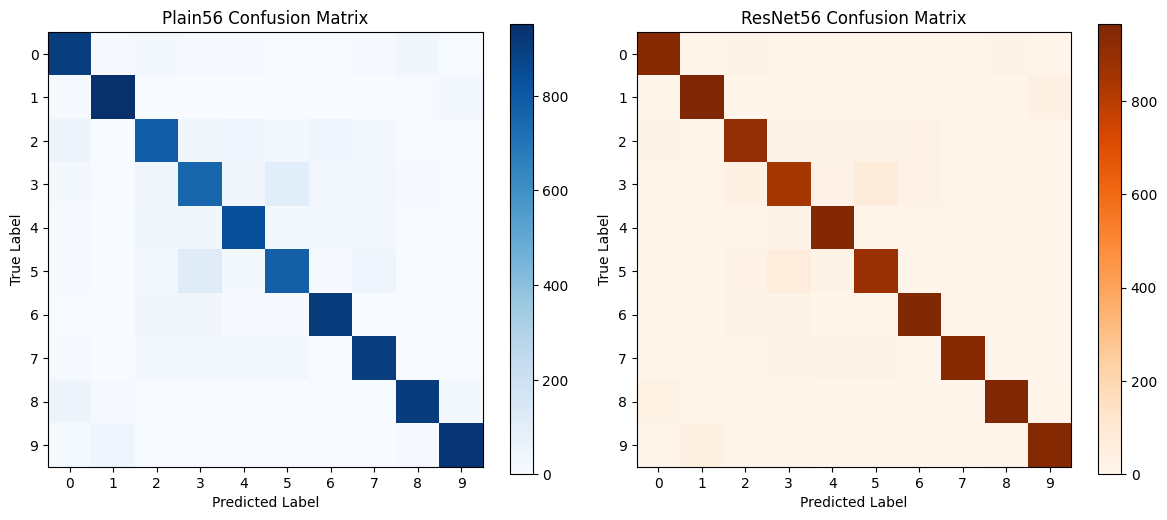

Plain56 Final Test Acc: 86.34%
ResNet56 Final Test Acc: 92.59%


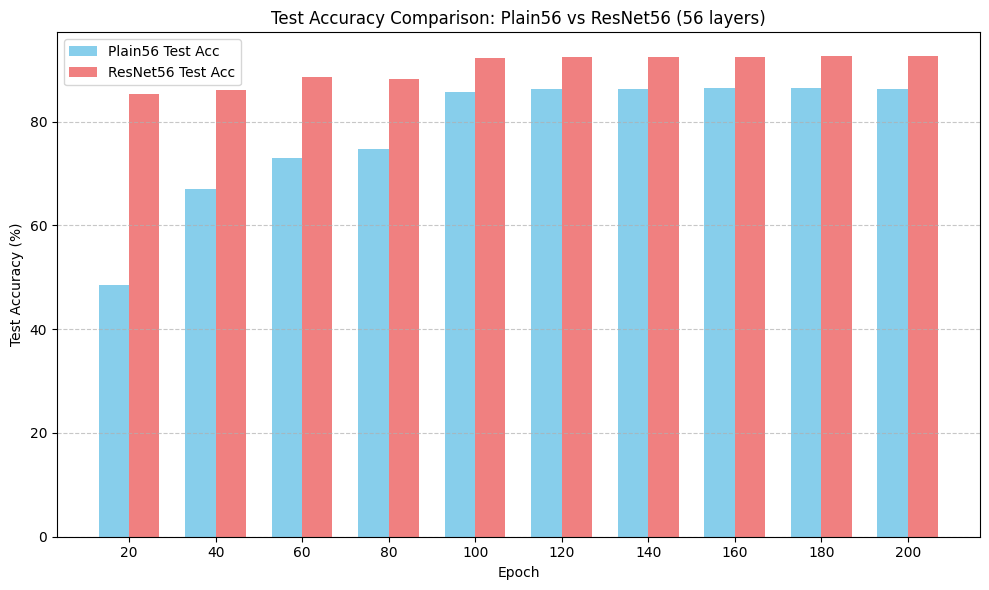

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Plots
epochs_range = range(200)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, plain_logs['test_acc'], label='Plain56 Test Acc')
plt.plot(epochs_range, res_logs['test_acc'], label='ResNet56 Test Acc')
plt.plot(epochs_range, plain_logs['train_acc'], label='Plain56 Train Acc', linestyle='--')
plt.plot(epochs_range, res_logs['train_acc'], label='ResNet56 Train Acc', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Curves (56 layers)')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, plain_logs['test_loss'], label='Plain56 Test Loss')
plt.plot(epochs_range, res_logs['test_loss'], label='ResNet56 Test Loss')
plt.plot(epochs_range, plain_logs['train_loss'], label='Plain56 Train Loss', linestyle='--')
plt.plot(epochs_range, res_logs['train_loss'], label='ResNet56 Train Loss', linestyle='--')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curves (56 layers)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
plt.savefig('accuracy_loss_56.png')
plt.close()

# Confusion Matrices
plt.figure(figsize=(12, 5))

for i, (name, model, color) in enumerate([('Plain56', plain_net, 'Blues'), ('ResNet56', res_net, 'Oranges')], 1):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    cm = confusion_matrix(all_labels, all_preds)

    plt.subplot(1, 2, i)
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.get_cmap(color))
    plt.title(f'{name} Confusion Matrix')
    plt.colorbar()
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.xticks(np.arange(10))
    plt.yticks(np.arange(10))

plt.tight_layout()
plt.show()
plt.savefig('confusion_56.png')
plt.close()

# Final Accuracies
print(f"Plain56 Final Test Acc: {plain_logs['test_acc'][-1]:.2f}%")
print(f"ResNet56 Final Test Acc: {res_logs['test_acc'][-1]:.2f}%")

# Data from the provided epochs
epochs = [20, 40, 60, 80, 100, 120, 140, 160, 180, 200]
plain56_acc = [48.46, 67.10, 73.04, 74.75, 85.76, 86.22, 86.39, 86.54, 86.52, 86.34]
resnet56_acc = [85.30, 86.17, 88.54, 88.24, 92.21, 92.41, 92.55, 92.54, 92.58, 92.59]

# Set the positions and width for the bars
bar_width = 0.35
index = np.arange(len(epochs))

# Create the bar chart
plt.figure(figsize=(10, 6))
plt.bar(index - bar_width/2, plain56_acc, bar_width, label='Plain56 Test Acc', color='skyblue')
plt.bar(index + bar_width/2, resnet56_acc, bar_width, label='ResNet56 Test Acc', color='lightcoral')

# Customize the chart
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy (%)')
plt.title('Test Accuracy Comparison: Plain56 vs ResNet56 (56 layers)')
plt.xticks(index, epochs)
plt.legend()
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

# Adjust layout and save
plt.tight_layout()
plt.show()
plt.savefig('test_accuracy_comparison.png')
plt.close()

# Optional: Display the chart (uncomment if running interactively)
# plt.show()
